<a href="https://colab.research.google.com/github/AlAntonov/poultry/blob/main/watershed_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
# download good sample image
!gdown --id 17uDkD5dt5JIr0z7nER0TJ3--_I-7FwQ8

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17uDkD5dt5JIr0z7nER0TJ3--_I-7FwQ8
To: /content/water_coins.jpg
100% 16.3k/16.3k [00:00<00:00, 16.3MB/s]


In [3]:
# download our video
!gdown --id 1r1E2NZ9r3AodYm-7PYR4mVUthRfb7fNa

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1r1E2NZ9r3AodYm-7PYR4mVUthRfb7fNa
To: /content/20210316-100031.mp4
100% 518M/518M [00:07<00:00, 71.9MB/s]


In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.measure import regionprops, label

In [5]:
%matplotlib inline

In [7]:
def get_video_frame(video):
  cap = cv2.VideoCapture(video)
  ret, frame = cap.read()

  return frame

In [8]:
def get_video_frame_num(video, frame_num):
    cap = cv2.VideoCapture(video)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num-1)
    res, frame = cap.read()

    return frame

In [9]:
def cluster_image(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)	
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  # noise removal
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
  # sure background area
  sure_bg = cv2.dilate(opening,kernel,iterations=3)
  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.9*dist_transform.max(),255,0)
  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  # Marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)
  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1
  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0
  markers = cv2.watershed(img,markers)
  
  regions = regionprops(markers)
  for r in regions:
    print(r.area)
  # regions = [r for r in regions if r.area > 5]
  print('Number of clusters:', len(regions) - 1)

  cluster_img = img.copy()
  cluster_img[markers == -1] = [255,0,0]
  cluster_img[markers != -1] = [255,255,255]
  return cluster_img

In [10]:
def resize_image(img, scale_percent=50):
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [11]:
def crop_image(img):
  # return img[int(img.shape[0]/6):int(3*img.shape[0]/6), int(img.shape[1]/3):int(2*img.shape[1]/3)]
  return img[int(img.shape[0]/3):int(2*img.shape[0]/3), int(img.shape[1]/3):int(2*img.shape[1]/3)]
  # return img[0:img.shape[0], 0:int(3*img.shape[1]/4)]

In [12]:
def increase_image_contrast(img):
  import cv2
  import numpy as np

  # converting to LAB color space
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  # feel free to try different values for the limit and grid size:
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))

  # Converting image from LAB Color model to BGR color spcae
  enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  return enhanced_img

In [13]:
def plot_four(img1, img2, img3, img4):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
  ax = axes.ravel()

  ax[0].imshow(img1)
  ax[0].set_title('Base frame')
  ax[1].imshow(img2)
  ax[1].set_title('Crop')
  ax[2].imshow(img3)
  ax[2].set_title('Denoising')
  ax[3].imshow(img4)
  ax[3].set_title('Clusters')

  for a in ax:
    a.set_axis_off()

  fig.tight_layout()
  plt.show()

Number of coins (method 1): 24
33244
1747
1720
1712
1676
1719
1752
1774
1695
1720
1726
1746
1667
1733
1729
1713
1745
1719
1702
1912
1533
1713
1818
1730
1711
Number of clusters: 24


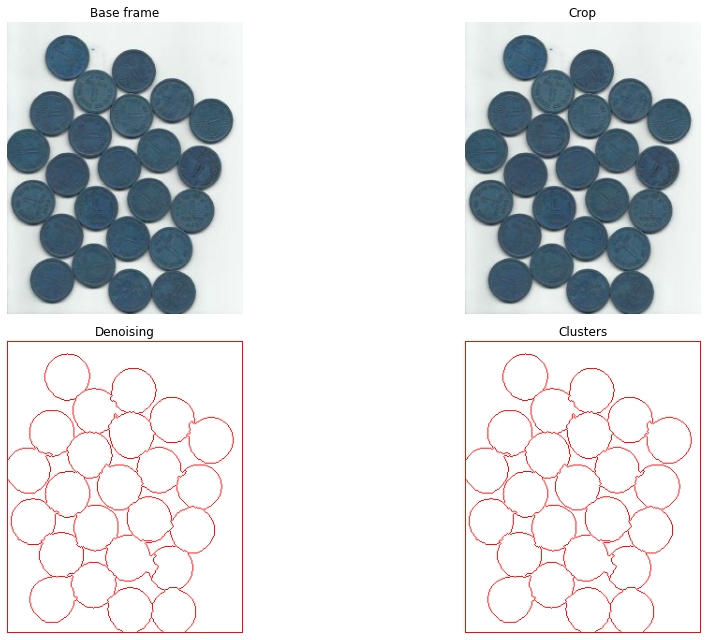

In [ ]:
img = cv2.imread('/content/water_coins.jpg')
# print('Image Dimensions :', img.shape)
img2 = cluster_image(img)

plot_four(img, img, img2, img2)

87297
138370
Number of clusters: 1


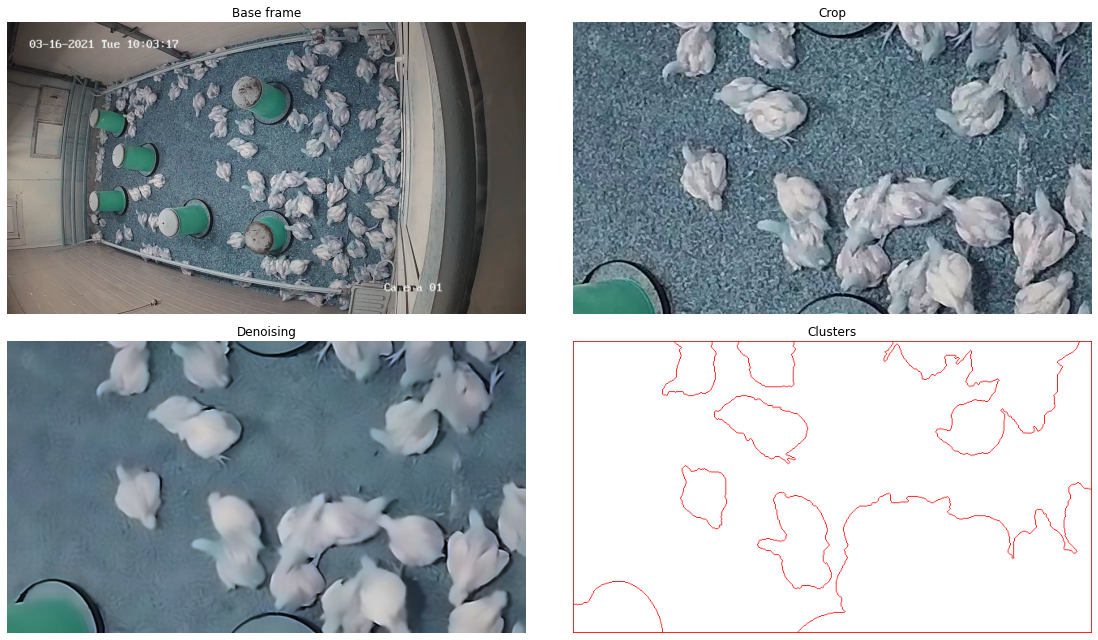

In [21]:
for i in range(3955, 3995, 40):
  img1 = get_video_frame_num('/content/20210316-100031.mp4', i)
  img2 = crop_image(img1)
  img3 = cv2.fastNlMeansDenoisingColored(img2,None,20,20,7,21)
  # img = increase_image_contrast(img)
  img4 = cluster_image(img3)

  plot_four(img1, img2, img3, img4)

17
87219
138401
Number of clusters: 1


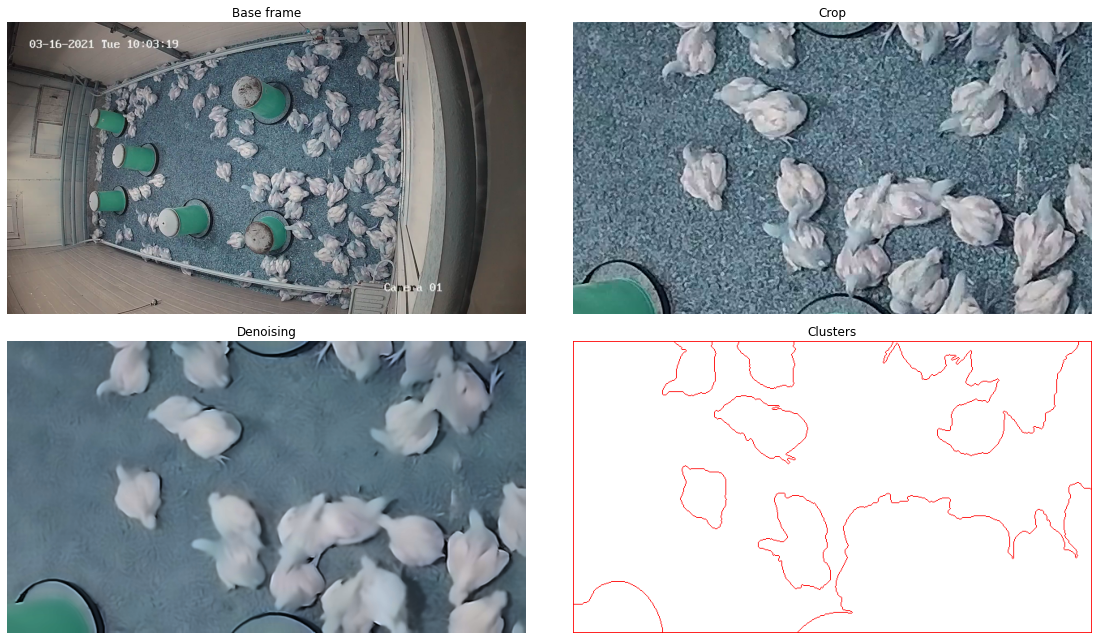

In [20]:
img2 = []
num_image = 8
frame_num = 3955
gap = 5
for i in range(frame_num-gap*num_image, frame_num+gap*num_image+1, gap):
  img1 = get_video_frame_num('/content/20210316-100031.mp4', i)
  img2.append(crop_image(img1))
print(len(img2))
img3 = cv2.fastNlMeansDenoisingColoredMulti(img2,num_image,num_image*2+1,None,20,20,7,21) # (img2,11,5)
img4 = cluster_image(img3)

plot_four(img1, img2[2], img3, img4)